## Import libraries

In [1]:
import tensorflow as tf
import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PATH="/content/drive/MyDrive/bachelor/data/pix2pix"

In [7]:
ppath = f'{PATH}/train/'

In [8]:
sample_path=f"{PATH}/train/augmented_1891261_49_1.jpg"
tf.io.read_file(sample_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\x00\x02\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x8

In [9]:
sample_image = tf.io.read_file(sample_path)
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


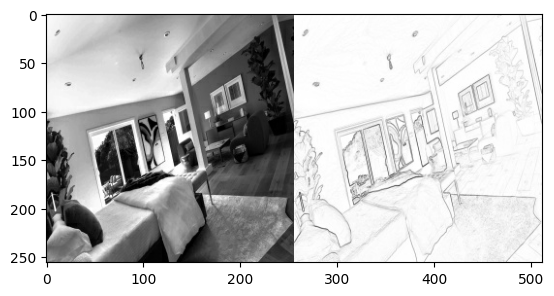

In [10]:
plt.figure()
plt.imshow(sample_image)

In [11]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image, real_image

In [14]:
 inp, re = load(f"{PATH}/train/augmented_1891261_49_1.jpg")


In [15]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [16]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [17]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [18]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [19]:
@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)

  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [20]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [21]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Build an input pipeline with `tf.data`

In [22]:
train_dataset = tf.data.Dataset.list_files(f"{PATH}/train/*.jpg")
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [23]:
try:
  test_dataset = tf.data.Dataset.list_files(f"{PATH}/val/*.jpg")
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(f"{PATH}/val/*.jpg")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

Define the downsampler (encoder):

In [24]:
OUTPUT_CHANNELS = 3

In [25]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [26]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))


Define the upsampler (decoder):

In [27]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [28]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Define the generator with the downsampler and the upsampler:

In [29]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),
    downsample(128, 4),
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4),
    upsample(64, 4),
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')
  x = inputs

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [30]:
LAMBDA = 100

In [31]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

Define the discriminator:

In [33]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])

  down1 = downsample(64, 4, False)(x)
  down2 = downsample(128, 4)(down1)
  down3 = downsample(256, 4)(down2)
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [40]:
generator = Generator()
discriminator = Discriminator()

Test the discriminator:

In [41]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Define the optimizers and a checkpoint-saver


In [42]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [44]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

## Training


In [45]:
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [46]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [47]:
import tqdm
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in tqdm.tqdm(train_ds.repeat().take(steps).enumerate()):
    if (step) % 500 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Finally, run the training loop:

Time taken for 1000 steps: 92.25 sec



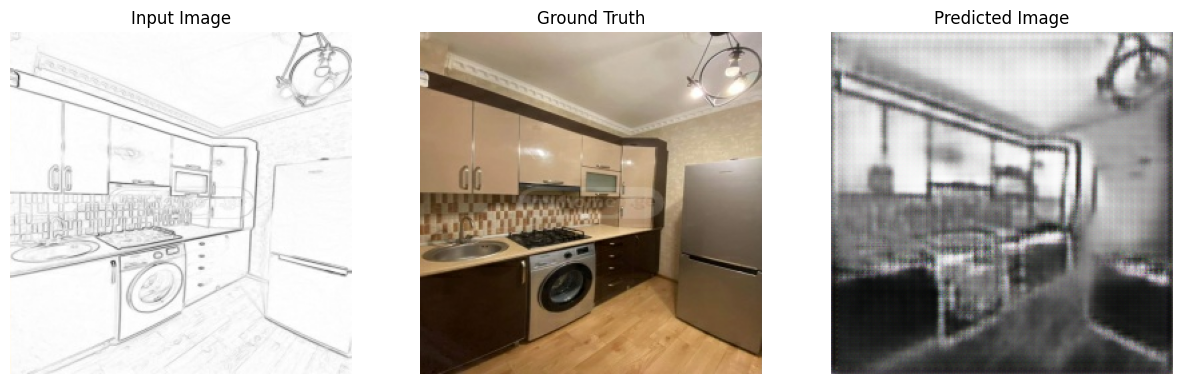

 50%|█████     | 501/1000 [03:58<01:57,  4.25it/s]

Step: 0k


 51%|█████     | 509/1000 [03:59<00:59,  8.30it/s]

.

 52%|█████▏    | 519/1000 [04:00<01:04,  7.44it/s]

.

 53%|█████▎    | 529/1000 [04:02<01:02,  7.50it/s]

.

 54%|█████▍    | 539/1000 [04:03<01:12,  6.32it/s]

.

 55%|█████▍    | 549/1000 [04:04<00:58,  7.75it/s]

.

 56%|█████▌    | 559/1000 [04:06<01:02,  7.09it/s]

.

 57%|█████▋    | 569/1000 [04:08<01:09,  6.20it/s]

.

 58%|█████▊    | 579/1000 [04:09<01:05,  6.47it/s]

.

 59%|█████▉    | 589/1000 [04:10<01:01,  6.68it/s]

.

 60%|█████▉    | 599/1000 [04:12<00:54,  7.30it/s]

.

 61%|██████    | 609/1000 [04:13<00:53,  7.25it/s]

.

 62%|██████▏   | 619/1000 [04:15<00:55,  6.85it/s]

.

 63%|██████▎   | 629/1000 [04:16<00:45,  8.19it/s]

.

 64%|██████▍   | 639/1000 [04:17<00:55,  6.54it/s]

.

 65%|██████▍   | 649/1000 [04:19<00:53,  6.59it/s]

.

 66%|██████▌   | 659/1000 [04:20<00:56,  6.04it/s]

.

 67%|██████▋   | 669/1000 [04:22<00:37,  8.79it/s]

.

 68%|██████▊   | 678/1000 [04:23<00:48,  6.68it/s]

.

 69%|██████▉   | 688/1000 [04:24<00:45,  6.80it/s]

.

 70%|██████▉   | 699/1000 [04:26<00:41,  7.30it/s]

.

 71%|███████   | 708/1000 [04:27<00:37,  7.75it/s]

.

 72%|███████▏  | 719/1000 [04:29<00:36,  7.60it/s]

.

 73%|███████▎  | 729/1000 [04:30<00:32,  8.28it/s]

.

 74%|███████▍  | 739/1000 [04:32<00:45,  5.68it/s]

.

 75%|███████▍  | 748/1000 [04:33<00:39,  6.38it/s]

.

 76%|███████▌  | 758/1000 [04:35<00:36,  6.69it/s]

.

 77%|███████▋  | 769/1000 [04:36<00:32,  7.20it/s]

.

 78%|███████▊  | 778/1000 [04:38<00:34,  6.53it/s]

.

 79%|███████▉  | 789/1000 [04:39<00:32,  6.50it/s]

.

 80%|███████▉  | 799/1000 [04:41<00:30,  6.60it/s]

.

 81%|████████  | 809/1000 [04:42<00:27,  6.93it/s]

.

 82%|████████▏ | 819/1000 [04:44<00:29,  6.06it/s]

.

 83%|████████▎ | 829/1000 [04:45<00:21,  8.05it/s]

.

 84%|████████▍ | 839/1000 [04:47<00:23,  6.77it/s]

.

 85%|████████▍ | 849/1000 [04:48<00:21,  7.05it/s]

.

 86%|████████▌ | 858/1000 [04:49<00:21,  6.61it/s]

.

 87%|████████▋ | 869/1000 [04:51<00:19,  6.76it/s]

.

 88%|████████▊ | 878/1000 [04:52<00:18,  6.47it/s]

.

 89%|████████▉ | 889/1000 [04:54<00:14,  7.53it/s]

.

 90%|████████▉ | 899/1000 [04:55<00:14,  6.97it/s]

.

 91%|█████████ | 908/1000 [04:57<00:14,  6.35it/s]

.

 92%|█████████▏| 919/1000 [04:58<00:11,  7.33it/s]

.

 93%|█████████▎| 928/1000 [04:59<00:08,  8.01it/s]

.

 94%|█████████▍| 939/1000 [05:01<00:07,  8.65it/s]

.

 95%|█████████▍| 949/1000 [05:02<00:05,  8.66it/s]

.

 96%|█████████▌| 959/1000 [05:04<00:05,  7.01it/s]

.

 97%|█████████▋| 969/1000 [05:05<00:04,  6.85it/s]

.

 98%|█████████▊| 979/1000 [05:06<00:02,  7.13it/s]

.

 99%|█████████▉| 989/1000 [05:08<00:01,  6.91it/s]

.

100%|█████████▉| 999/1000 [05:09<00:00,  6.51it/s]

.

100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


In [49]:
fit(train_dataset, test_dataset, steps=1000)

In [50]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

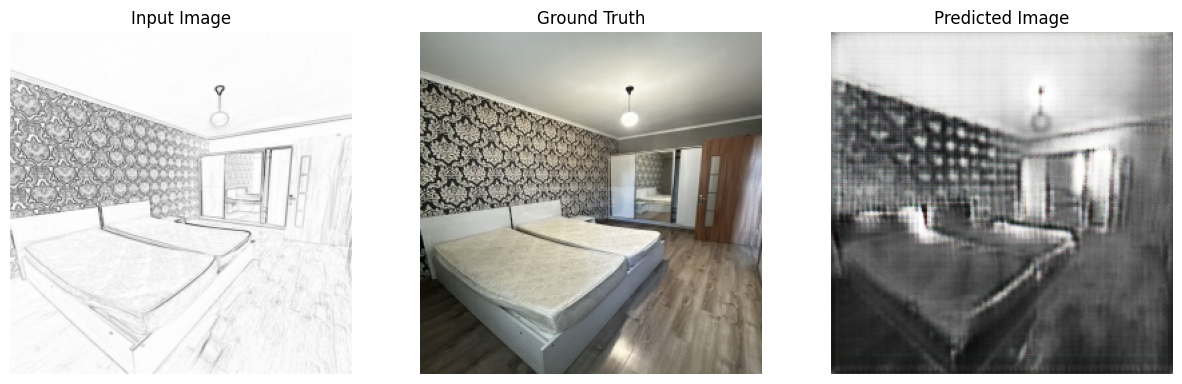

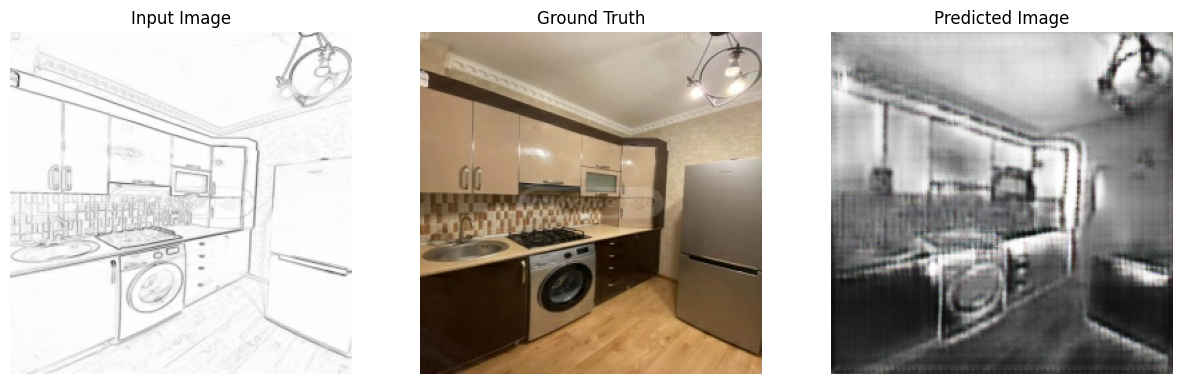

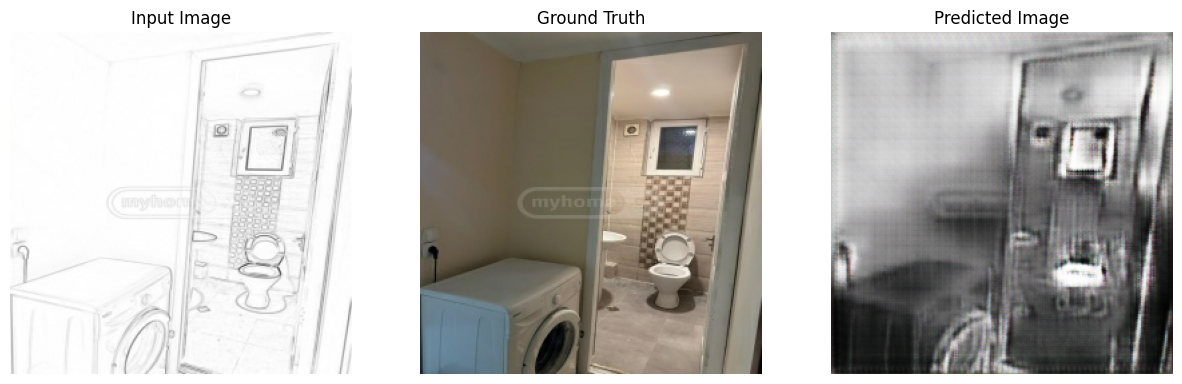

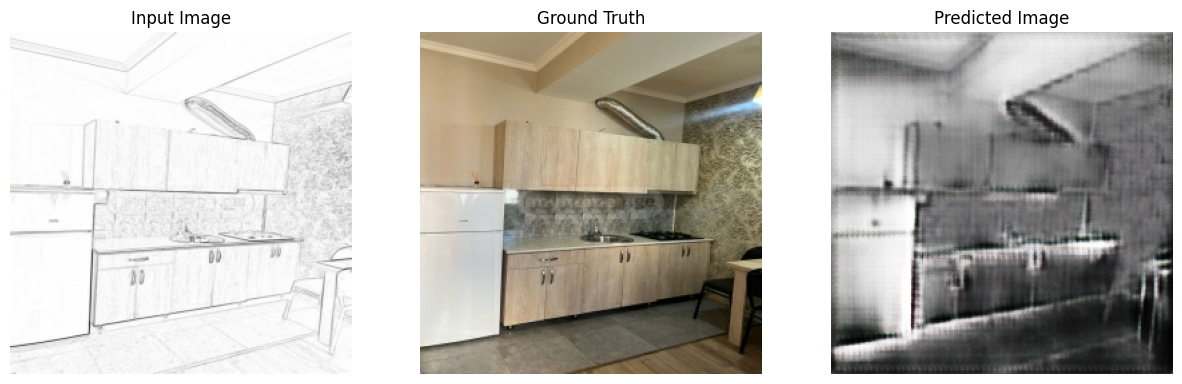

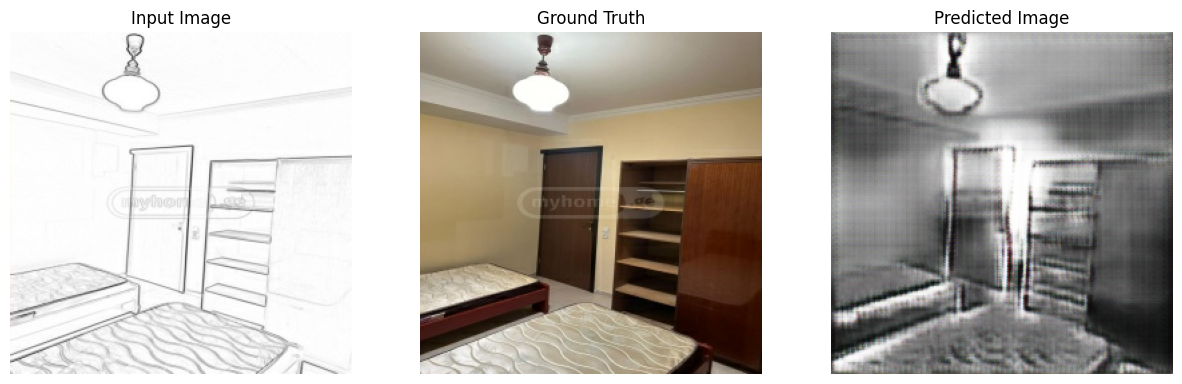

In [51]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)